In [1]:
import imageio.v2 as imageio

In [77]:
img = imageio.imread("data/Profile.jpg") /255


In [78]:
img.shape

(665, 664, 3)

In [79]:
import matplotlib.pyplot as plt
import numpy as np

(np.float64(-0.5), np.float64(663.5), np.float64(664.5), np.float64(-0.5))

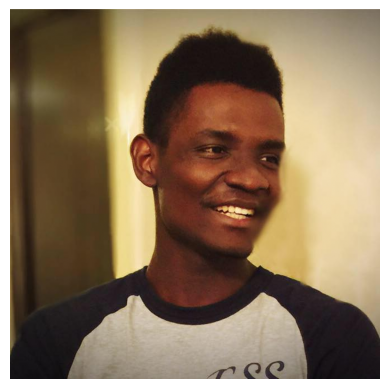

In [81]:
plt.imshow(img)
plt.axis('off')

In [82]:
noise = np.random.rand(*img.shape)

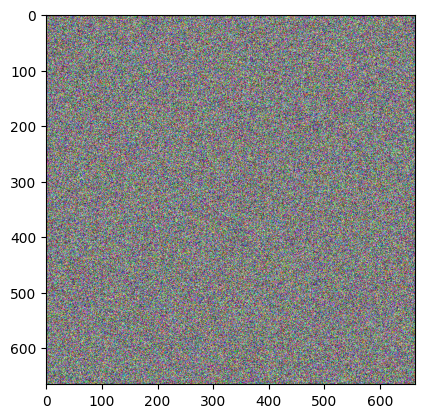

In [83]:
plt.imshow(noise)

## adding gaussian noise

In [87]:
def scale_image_into_range(image, min_range =  0, max_range = 1):
    """
    Scale image into range [min_range, max_range]
    """
    img_s = (image - image.min())/(image.max() - image.min()) # scaled to 0-1 range
    return min_range + (max_range - min_range)*img_s

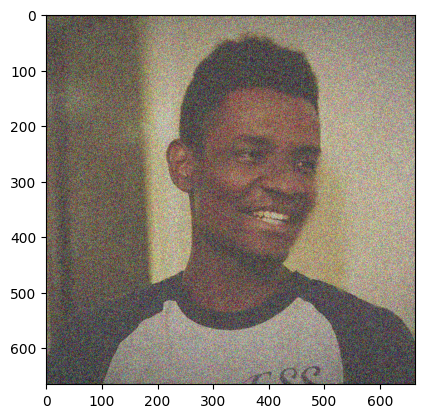

In [88]:
img_pert = scale_image_into_range(img + noise) # Adding noise
plt.imshow(img_pert)

## Masking 

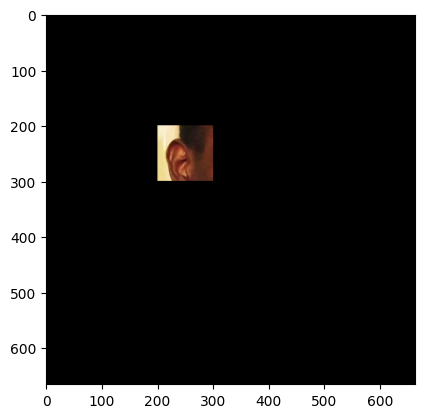

In [51]:
mask_size = 100
mask_start = 200
img_copy = img.copy()
mask = np.zeros_like(img_copy)
mask[mask_start:mask_size + mask_start, mask_start:mask_size + mask_start,:] = 1
plt.imshow(img*mask)

# Spatial transformation

### Per-pixel transformtion

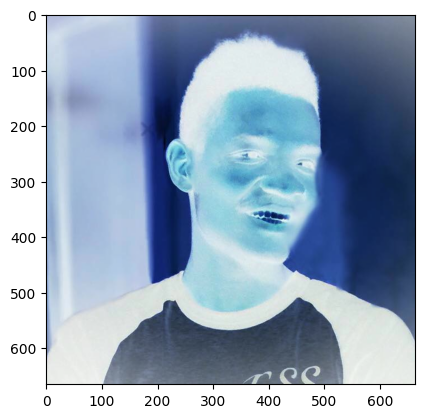

In [100]:
img_negative = scale_image_into_range(255-img)
plt.imshow(img_negative) # image negative


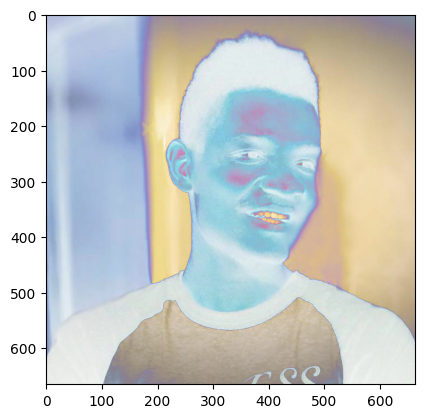

In [101]:
img_union =  np.maximum(img, img_negative)
plt.imshow(img_union)

### Neighboorhood transformation

In [267]:
import numpy as np

def neighborhood_transform(img, f=np.mean, n_neighbors=8):
    if n_neighbors % 8 != 0:
        raise ValueError("parameter n_neighbors should be a multiple of 8.")
    
    try:
        m, n = img.shape
        is_color = False
    except ValueError:
        m, n, _ = img.shape
        is_color = True

    out = np.zeros_like(img, dtype=float)
    span = n_neighbors // 8
    span_pp = span + 1

    for i in range(m):
        for j in range(n):
            # clamp window coordinates
            i0 = max(i - span, 0)
            i1 = min(i + span_pp, m)
            j0 = max(j - span, 0)
            j1 = min(j + span_pp, n)

            window = img[i0:i1, j0:j1, ...]

            # apply function
            if is_color:
                window = window.reshape((-1,3))
                val = f(window,axis=0 )
            else:
                val = f(window)

            out[i, j, ...] = val

    return out

In [262]:
test_img = np.arange(1,26).reshape((5,5))


In [263]:
neighborhood_transform(test_img, n_neighbors=16)

array([[ 7. ,  7.5,  8. ,  8.5,  9. ],
       [ 9.5, 10. , 10.5, 11. , 11.5],
       [12. , 12.5, 13. , 13.5, 14. ],
       [14.5, 15. , 15.5, 16. , 16.5],
       [17. , 17.5, 18. , 18.5, 19. ]])

In [268]:
img_blur = neighborhood_transform(img, n_neighbors=16)

In [400]:
def show_images_grid(images,figsize =(10, 10), titles=None):
    heights = [img.shape[0] for img in images]
    widths = [img.shape[1] for img in images]
    max_h, max_w = max(heights), max(widths)
    
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:
        axes = [axes]
    for i, (ax, img) in enumerate(zip(axes, images)):
        scale = img.shape[1] / max_w
        ax.imshow(img)
        ax.set_aspect('equal')
        ax.set_title(titles[i] if titles else f"{img.shape}")
        # Shrink axis according to image size
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * scale, box.height * scale])
        ax.axis("off")
    plt.show()


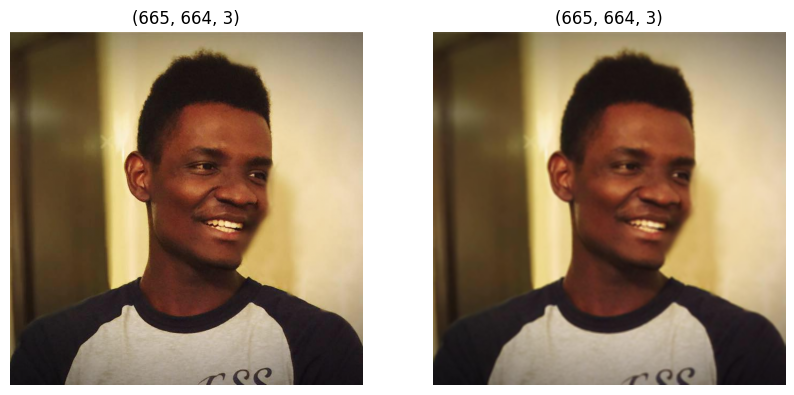

In [269]:
show_images_grid((img,img_blur))

## Geometric spatial transformation

In [214]:
def scale_image(img, sx, sy):
    H, W = img.shape[:2]
    H_out, W_out = int(H * sy), int(W * sx)
    out = np.zeros((H_out, W_out, *img.shape[2:]), dtype=img.dtype)

    y_prime, x_prime = np.meshgrid(np.arange(H_out), np.arange(W_out), indexing='ij')
    # inverse mapping
    x = x_prime / sx
    y = y_prime / sy

    # floor and ceil for bilinear
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    x1 = np.clip(x0 + 1, 0, W - 1)
    y1 = np.clip(y0 + 1, 0, H - 1)

    # fractional parts
    wx = x - x0
    wy = y - y0
    wx = wx[...,np.newaxis]
    wy = wy[...,np.newaxis]

    # gather 4 neighbors and interpolate
    Ia = img[y0, x0,:]
    Ib = img[y0, x1,:]
    Ic = img[y1, x0,:]
    Id = img[y1, x1,:]

    out = (
        Ia * (1 - wx) * (1 - wy)
        + Ib * wx * (1 - wy)
        + Ic * (1 - wx) * wy
        + Id * wx * wy
    )

    return out


In [228]:
img_scaled = scale_image(img, 2,2)

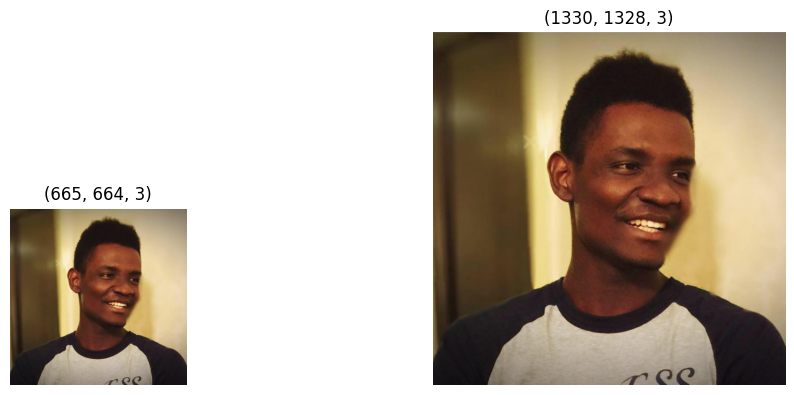

In [229]:
show_images_grid((img,img_scaled))

In [248]:
def rotate_image(image, theta=30):
    H, W = image.shape[:2]
    theta = np.deg2rad(theta)
    cx, cy = W / 2, H / 2

    y_prime, x_prime = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    out = np.zeros((H, W, *image.shape[2:]), dtype=image.dtype)

    # Inverse mapping (destination → source)
    x_c = x_prime - cx
    y_c = y_prime - cy
    x =  np.cos(theta)*x_c + np.sin(theta)*y_c + cx
    y = -np.sin(theta)*x_c + np.cos(theta)*y_c + cy

    # Valid pixel mask
    mask = (x >= 0) & (x < W-1) & (y >= 0) & (y < H-1)

    # Floor/ceil for interpolation
    x0 = np.clip(np.floor(x).astype(int), 0, W - 2)
    y0 = np.clip(np.floor(y).astype(int), 0, H - 2)
    x1 = x0 + 1
    y1 = y0 + 1


    Ia = image[y0, x0, ...]
    Ib = image[y0, x1, ...]
    Ic = image[y1, x0, ...]
    Id = image[y1, x1, ...]

    wx = x - x0
    wy = y - y0
    wx = wx[...,np.newaxis]
    wy = wy[..., np.newaxis]

    out = (
        Ia * (1 - wx) * (1 - wy)
        + Ib * wx * (1 - wy)
        + Ic * (1 - wx) * wy
        + Id * wx * wy
    )

    out[~mask] = 0
    return out


In [251]:
img_rot = rotate_image(img, -30)

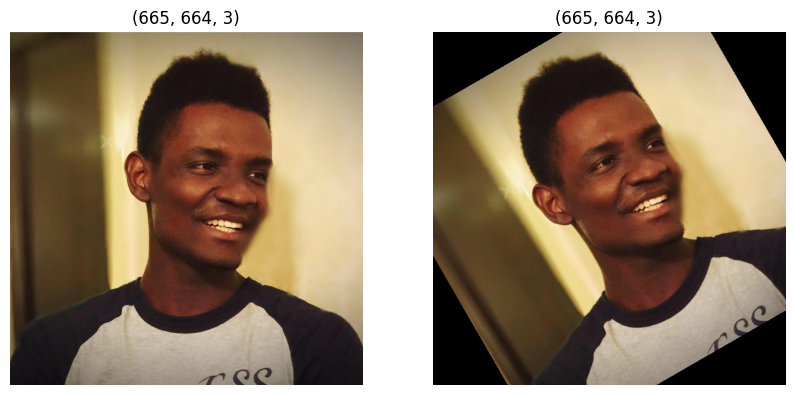

In [252]:
show_images_grid((img,img_rot))

# 3. Intensity Transformations and Spatial Filtering

### Intensity transformation

In [296]:
def is_pixel_scaled(img):
    return img.max() <= 1

def image_negative(img):
    L = 1 if is_pixel_scaled(img) else 255
    return np.clip(L - img,0,L)

def log_transform(img, c = 1):
    if is_pixel_scaled(img):
        img= scale_image_into_range(img,max_range=255)
    out = c*np.log(img+1)
    return scale_image_into_range(out)

def power_law_transform(img, c = 1, gamma = 1):
    if is_pixel_scaled(img):
        img =  img= scale_image_into_range(img,max_range=255)
    return scale_image_into_range(c*img**gamma)

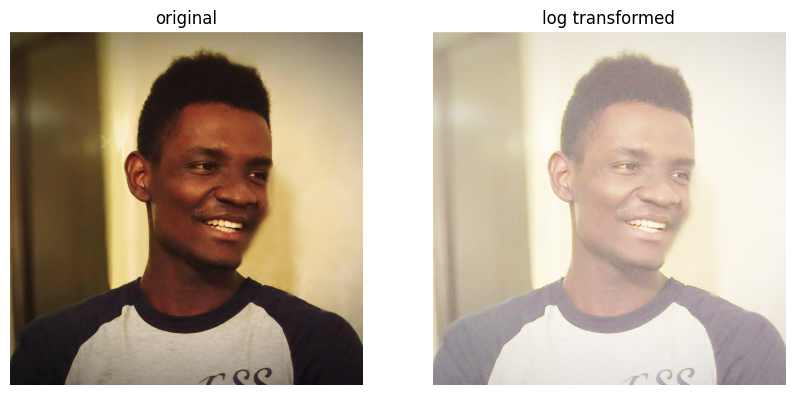

In [290]:
show_images_grid((img,log_transform(img, c =2)), titles = ("original", "log transformed"))

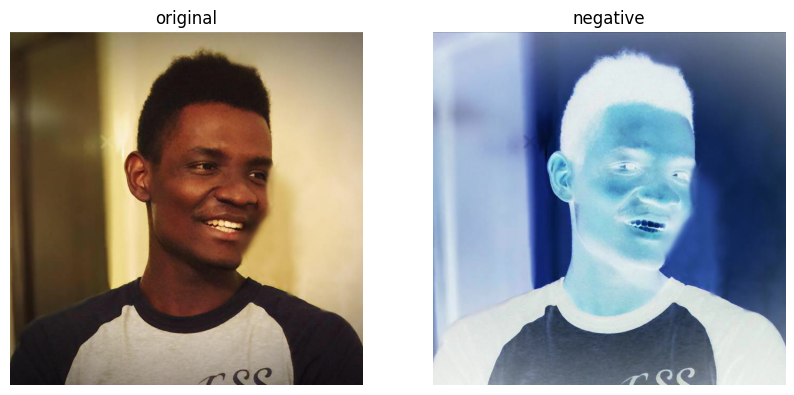

In [291]:
show_images_grid((img,image_negative(img)), titles = ("original", "negative"))

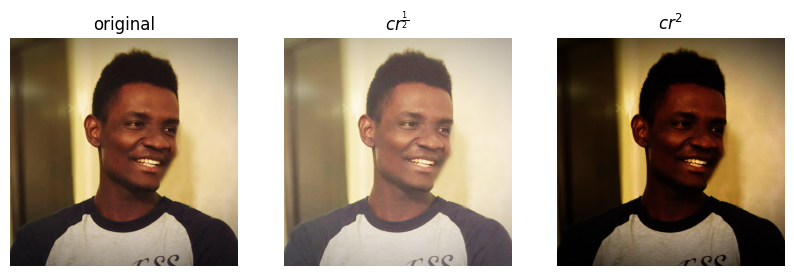

In [302]:
img_p1 = power_law_transform(img, gamma = .5)
img_p2 = power_law_transform(img, gamma = 2)
show_images_grid((img,img_p1, img_p2), titles = ("original", r"$cr^\frac{1}{2}$",r"$cr^2$"))

In [327]:
def sigmoid(x, a = 1):
    return 1 / (1 + np.exp(-a*x))

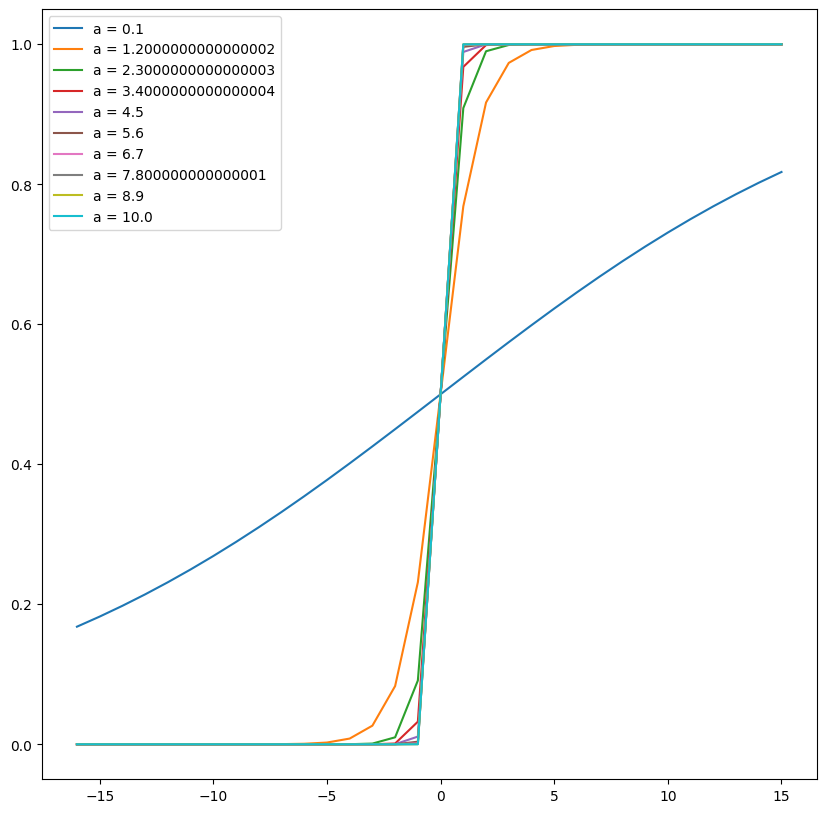

In [342]:
fig, ax = plt.subplots(figsize = (10,10))
x = np.arange(-16,16)
for i in np.linspace(1e-1,10,10):
    ax.plot(x,sigmoid(x,i), label = f"a = {i}")
ax.legend()

In [332]:
def contrast(img,*arg,**kws):
    if is_pixel_scaled(img):
        img = scale_image_into_range(img, max_range=255)
    img = scale_image_into_range(img, min_range = -1, max_range=1)
    return scale_image_into_range(sigmoid(img,*arg,**kws))
    

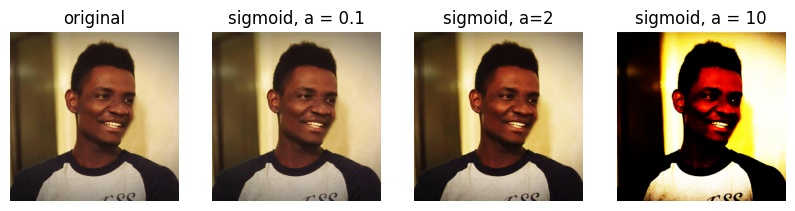

In [348]:
show_images_grid((img, contrast(img,.1),contrast(img,2),contrast(img,10)), titles = ("original","sigmoid, a = 0.1", "sigmoid, a=2", "sigmoid, a = 10"))

- piece-wise linear transformation
- intensity-level-slicing
- Bit-plane slicing

In [413]:
def bit_plane_decomposition(img, bitsize = 8):
    if is_pixel_scaled(img):
        img = scale_image_into_range(img, max_range=255)
        
    assert ~(bitsize%2), "parameter bitsize must be multiple of 2"
    out = []
    for i in reversed(range(0,bitsize)):
        divider = 2**i
        out.append(img//divider)
        img %= divider
        
    return out

def bit_plane_reconst_img(imgs, idx_list,bitsize = 8):
    assert np.max(idx_list) < bitsize, f"idx_list must be between [0, {bitsize})"
    n = bitsize - 1
    out = np.zeros_like(imgs[0])
    for i in idx_list:
        out += imgs[i]*(2**(n-i))
    return out
    

In [387]:
decom_img = bit_plane_decomposition(img)

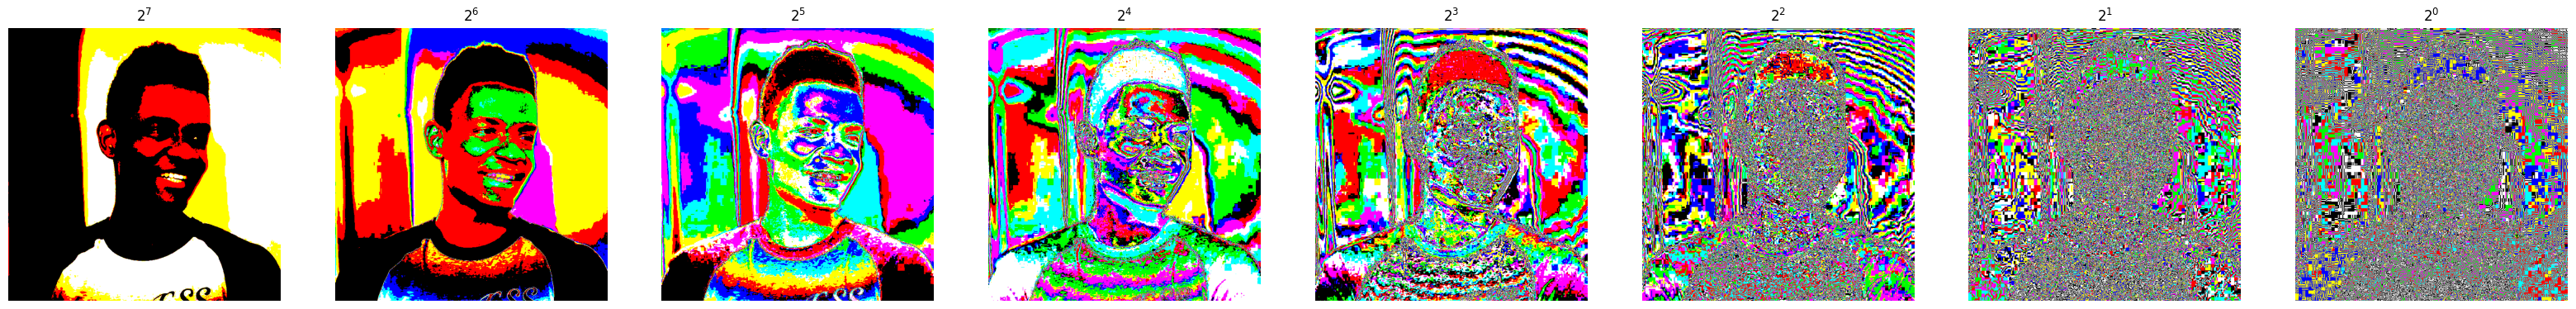

In [ ]:
show_images_grid(decom_img,figsize = (40,80), titles = (r"$2^7$",r"$2^6$",r"$2^5$",r"$2^4$",r"$2^3$",r"$2^2$",r"$2^1$",r"$2^0$"))

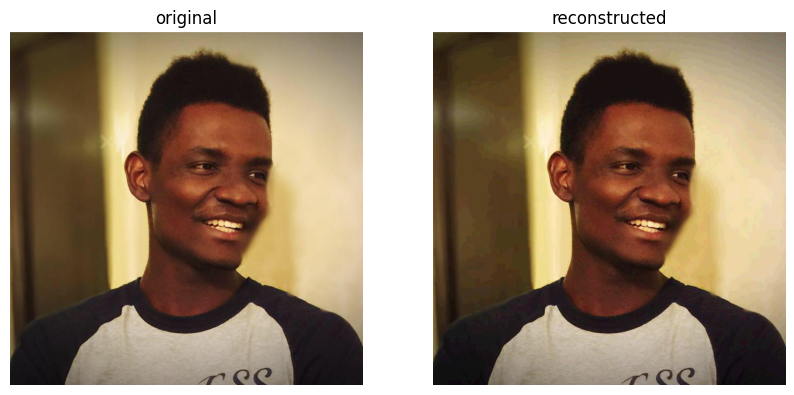

In [416]:
img_reconstructed = scale_image_into_range(bit_plane_reconst_img(decom_img, [0,1,2,3,4]))
show_images_grid((img, img_reconstructed), titles = ("original", "reconstructed"))

## Histogram processing